# Detekcija Alzheimerove bolesti na MRI slikama mozga

In [437]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import sklearn.metrics as metrics
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
import warnings
from sklearn.utils import shuffle
import random
from tensorflow.keras.applications import EfficientNetV2L
from efficientnet.tfkeras import EfficientNetB3, EfficientNetB0
import tensorflow as tf
from keras import applications
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
import itertools

warnings.filterwarnings('ignore')

In [438]:
labels = ['Non_Demented', 'Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented']
classes = {'Non_Demented': 0,'Mild_Demented': 1,'Moderate_Demented': 2, 'Very_Mild_Demented': 3}

## Učitavanje podataka

Ne znam dal treba ni kako treba obradit te podatke tbh.

In [8]:
X = []
Y = []

image_size = 150

for label in labels:
    folderPath = os.path.join('Data', 'Dataset', label)
    for im in tqdm(os.listdir(folderPath)):
        img = cv2.imread(folderPath + "\\" + im)
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
        img = cv2.medianBlur(img, 5)
        X.append(img)
        Y.append(label)

100%|██████████| 2240/2240 [00:01<00:00, 1124.55it/s]


In [9]:
X = np.array(X)
Y = np.array(Y)

## EDA

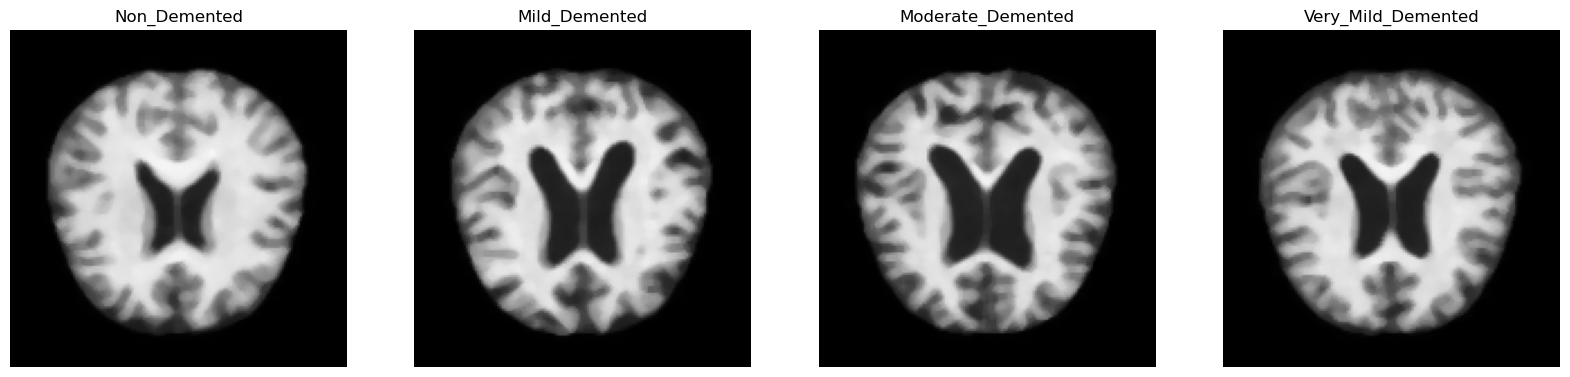

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(20,20))

k = 0
for label in labels:
    for j in range(0, len(X)):
        if Y[j] == label:
            ax[k].imshow(X[j])
            ax[k].set_title(Y[j])
            ax[k].axis('off')
            break
    k+=1

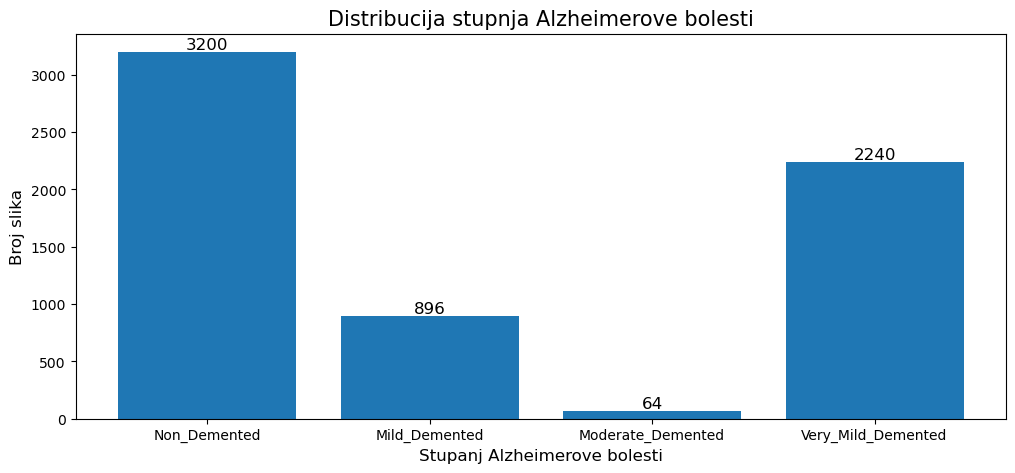

In [11]:
counter = Counter(Y)
freqs = [counter[label] for label in labels]

fig, ax = plt.subplots(figsize=(12, 5))

bars = plt.bar(labels, freqs)
ax.bar_label(bars, size=12)

ax.set_xlabel("Stupanj Alzheimerove bolesti", fontsize=12)
ax.set_ylabel("Broj slika", fontsize=12)
ax.set_title("Distribucija stupnja Alzheimerove bolesti", fontsize=15)

plt.show()

## Modeli za klasifikaciju Alzheimerove bolesti

## Pomoćne funkcije

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [474]:
def plot_accuracy_and_loss_graphs(history, num_epochs=25):
    epochs = [i for i in range(num_epochs)]
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots(1, 2, figsize = (14, 7))

    #sns.despine()
    ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='green',color='green',
           label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Accuracy on training and validation set')

    #sns.despine()
    ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='green',color='green',
           label ='Training Loss')
    ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Loss on training and validation set')

    fig.show()

In [12]:
def choose_random_picture(label, X, Y):
    images_with_label = []
    for img, c in zip(X, Y):
        if c == classes[label]:
            images_with_label.append(img)
    index = random.randint(0, len(images_with_label)-1)
    img = X[index]
    return img

### 1. SVM

In [13]:
def svm(svm_model, X_train, X_test, Y_train, Y_test):
    svm_model.fit(X_train, Y_train)
    Y_pred = svm_model.predict(X_train)
    print("Mjere tocnosti na skupu za treniranje:")
    print(metrics.classification_report(Y_train, Y_pred, target_names = classes))
    Y_pred = svm_model.predict(X_test)
    print("Mjere tocnosti na skupu za testiranje:")
    print(metrics.classification_report(Y_test, Y_pred, target_names = classes))
    return svm_model

In [14]:
Y_class = []
for y in Y:
    Y_class.append(classes[y])

In [15]:
X_reshaped = X.reshape(len(X), -1)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_class, train_size = 0.75, stratify = Y_class, shuffle = True, random_state=357)

In [17]:
#X_train = np.array(X_train).reshape(len(X_train), -1)
#X_test = np.array(X_test).reshape(len(X_test), -1)

In [18]:
svm_model_1 = SVC(kernel='linear')
svm_model_1 = svm(svm_model_1, X_train, X_test, Y_train, Y_test)

Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       1.00      1.00      1.00      2400
     Mild_Demented       1.00      1.00      1.00       672
 Moderate_Demented       1.00      1.00      1.00        48
Very_Mild_Demented       1.00      1.00      1.00      1680

          accuracy                           1.00      4800
         macro avg       1.00      1.00      1.00      4800
      weighted avg       1.00      1.00      1.00      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.98      0.98      0.98       800
     Mild_Demented       0.99      0.96      0.97       224
 Moderate_Demented       1.00      1.00      1.00        16
Very_Mild_Demented       0.96      0.98      0.97       560

          accuracy                           0.98      1600
         macro avg       0.98      0.98      0.98      1600
      weighted av

In [19]:
svm_model_2 = SVC(kernel='poly', degree=2)
svm_model_2 = svm(svm_model_2, X_train, X_test, Y_train, Y_test)

Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       0.79      0.91      0.85      2400
     Mild_Demented       0.96      0.43      0.60       672
 Moderate_Demented       1.00      0.17      0.29        48
Very_Mild_Demented       0.72      0.74      0.73      1680

          accuracy                           0.78      4800
         macro avg       0.87      0.56      0.61      4800
      weighted avg       0.79      0.78      0.76      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.77      0.89      0.82       800
     Mild_Demented       0.97      0.33      0.50       224
 Moderate_Demented       0.00      0.00      0.00        16
Very_Mild_Demented       0.66      0.71      0.68       560

          accuracy                           0.74      1600
         macro avg       0.60      0.48      0.50      1600
      weighted av

In [20]:
def get_label_by_class(c):
    for key, value in classes.items():
        if value == c:
            return key
    return None

In [29]:
c = random.randint(0, len(labels)-1)
y_true_example = labels[c]
random_image = choose_random_picture(y_true_example, X_test, Y_test)

#img = cv2.resize(random_image, (image_size,image_size))
img = random_image.reshape(1,-1)

y_pred_example = svm_model_2.predict(img)

print("true class = " + y_true_example + "\npredicted_class = " + get_label_by_class(y_pred_example[0]))

true class = Non_Demented
predicted_class = Non_Demented


### 2. EfficientNet

In [31]:
#!pip install -U efficientnet

In [451]:
image_size = 224
learning_rate = 0.01
learning_rate_delta = 0.001
num_epochs = 25

#### Ponovno učitavanje podatka (+ mijenjanje dimenzija)

In [452]:
X = []
Y = []

for label in labels:
    folderPath = os.path.join('Data', 'Dataset', label)
    for im in tqdm(os.listdir(folderPath)):
        img = cv2.imread(folderPath + "\\" + im)
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
        img = cv2.medianBlur(img, 5)
        X.append(img)
        Y.append(label)

100%|██████████| 2240/2240 [00:18<00:00, 121.78it/s]


In [453]:
X = np.array(X)
Y = np.array(Y)

In [454]:
Y_class = []
for y in Y:
    Y_class.append(classes[y])
Y_one_hot = tf.keras.utils.to_categorical(Y_class)

In [455]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, train_size = 0.75, stratify = Y_class, 
                                                    shuffle = True, random_state=357)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

#### Model

In [456]:
EfficientNetModel = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model = EfficientNetModel.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(len(labels), activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNetModel.input, outputs=model)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_51 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_13 (Rescaling)    (None, 224, 224, 3)          0         ['input_51[0][0]']            
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_13[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_14 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_4[0][0]'

In [457]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])

In [458]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("efficientnetb0.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False,
                                                mode='auto', save_freq='epoch')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_delta=learning_rate_delta)

#### Treniranje modela

In [459]:
history = model.fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(Y_train),
                    epochs=num_epochs,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/25
135/135 [==============================] - ETA: 0s - loss: 1.0438 - accuracy: 0.5183
Epoch 1: val_accuracy improved from -inf to 0.49583, saving model to efficientnetb0.h5
135/135 [==============================] - 367s 3s/step - loss: 1.0438 - accuracy: 0.5183 - val_loss: 5.3982 - val_accuracy: 0.4958 - lr: 0.0100
Epoch 2/25
135/135 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.5664
Epoch 2: val_accuracy improved from 0.49583 to 0.51042, saving model to efficientnetb0.h5
135/135 [==============================] - 330s 2s/step - loss: 0.8996 - accuracy: 0.5664 - val_loss: 0.9784 - val_accuracy: 0.5104 - lr: 0.0100
Epoch 3/25
135/135 [==============================] - ETA: 0s - loss: 0.8153 - accuracy: 0.6116
Epoch 3: val_accuracy did not improve from 0.51042
135/135 [==============================] - 330s 2s/step - loss: 0.8153 - accuracy: 0.6116 - val_loss: 2.8060 - val_accuracy: 0.4938 - lr: 0.0100
Epoch 4/25
135/135 [=============================

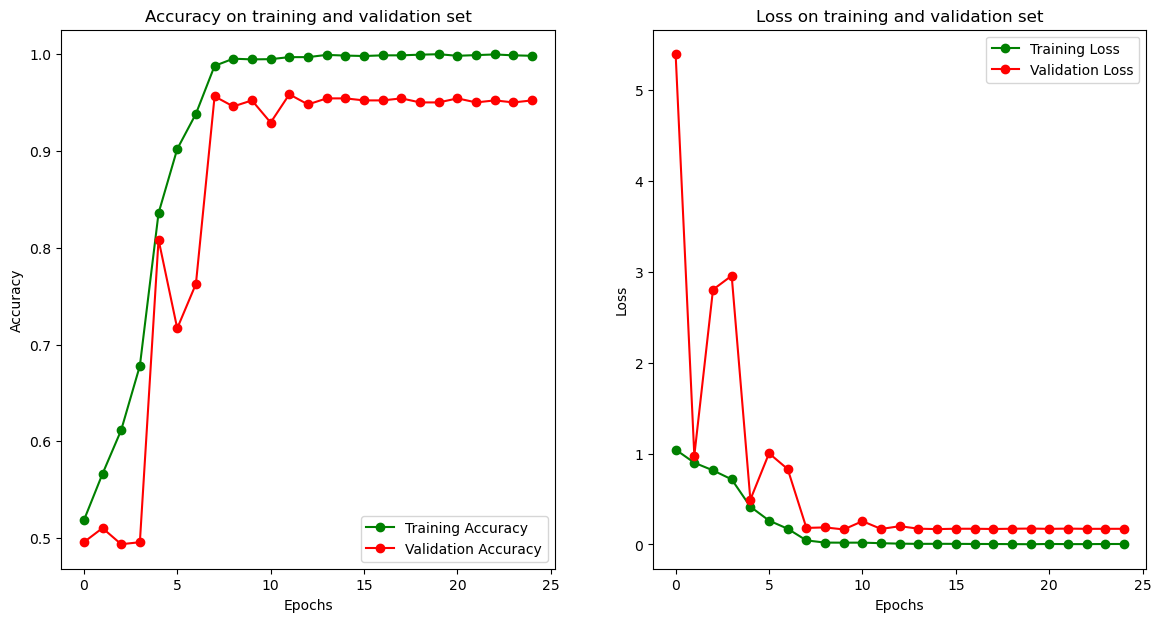

In [475]:
plot_accuracy_and_loss_graphs(history, num_epochs)

#### Predviđanje

In [476]:
prediction = model.predict(tf.convert_to_tensor(X_test))

50/50 [==============================] - 25s 509ms/step


In [477]:
Y_pred = []
for row in prediction:
  index = np.argmax(row)
  Y_pred.append(index)

#print(Y_pred)
Y_true = np.argmax(Y_test, axis=1)
#print(Y_true)

#### Evaluacija modela

In [478]:
print(metrics.classification_report(Y_true, Y_pred, target_names=classes))

                    precision    recall  f1-score   support

      Non_Demented       0.97      0.98      0.97       800
     Mild_Demented       0.96      0.92      0.94       224
 Moderate_Demented       0.88      0.94      0.91        16
Very_Mild_Demented       0.94      0.94      0.94       560

          accuracy                           0.96      1600
         macro avg       0.94      0.94      0.94      1600
      weighted avg       0.96      0.96      0.96      1600



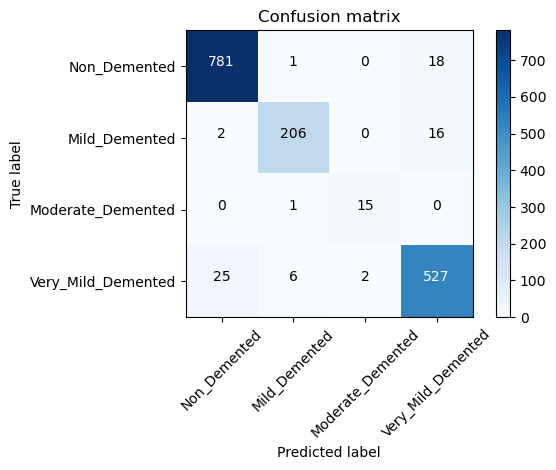

In [479]:
plot_confusion_matrix(metrics.confusion_matrix(Y_true, Y_pred), classes=labels)

### 3. GoogLeNet

In [354]:
image_size = 224 # jer je takva dimenzija ulaza u googlenetu
num_epochs = 25
batch_size = 30

#### Ponovno učitavanje podatka (+ mijenjanje dimenzija)

In [355]:
X = []
Y = []

image_size = 150

for label in labels:
    folderPath = os.path.join('Data', 'Dataset', label)
    for im in tqdm(os.listdir(folderPath)):
        img = cv2.imread(folderPath + "\\" + im)
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
        img = cv2.medianBlur(img, 5)
        X.append(img)
        Y.append(label)

100%|██████████| 2240/2240 [00:40<00:00, 54.80it/s]


In [356]:
X = np.array(X)
Y = np.array(Y)

In [357]:
Y_class = []
for y in Y:
    Y_class.append(classes[y])
Y_one_hot = tf.keras.utils.to_categorical(Y_class)

In [344]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, train_size = 0.75, stratify = Y_class, 
                                                    shuffle = True, random_state=357)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

#### Izgradnja GoogLeNet modela

In [358]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 

    conv1x1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    conv3x3_reduce  = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    conv3x3 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(conv3x3_reduce)

    conv5x5_reduce = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    conv5x5 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(conv5x5_reduce)

    maxpool = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    maxpool_proj = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(maxpool)

    output_layer = Concatenate(axis = -1)([conv1x1, conv3x3, conv5x5, maxpool_proj])

    return output_layer

In [359]:
def GoogLeNet(input_shape, num_classes):
    input_layer = Input(shape = input_shape)
    
    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'same', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # Inception block 3a
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # Inception block 3b
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # Inception block 4a
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Inception block 4b
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # Inception block 4c
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # Inception block 4d
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Inception block 4e
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32,  f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = AveragePooling2D(pool_size=(7, 7), strides=1)(X)

    # Inception block 5a
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # Inception block 5b
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(num_classes, activation = 'softmax')(X)

    # model
    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

In [324]:
tensorboard_GGN = TensorBoard(log_dir = 'logs')

checkpoint_GGN = ModelCheckpoint("googlenet.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

#### Treniranje modela

In [326]:
model_GGN = GoogLeNet((image_size, image_size, 3), len(labels))

model_GGN.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

history = model_GGN.fit(X_train,
                        Y_train,
                        validation_split=0.1,
                        epochs = num_epochs,
                        verbose=1,
                        batch_size=batch_size,
              callbacks=[tensorboard_GGN, checkpoint_GGN])

Epoch 1/25
144/144 [==============================] - ETA: 0s - loss: 1.0664 - accuracy: 0.4877
Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to googlenet.h5
144/144 [==============================] - 91s 506ms/step - loss: 1.0664 - accuracy: 0.4877 - val_loss: 0.9846 - val_accuracy: 0.5167
Epoch 2/25
144/144 [==============================] - ETA: 0s - loss: 0.9538 - accuracy: 0.5440
Epoch 2: val_accuracy improved from 0.51667 to 0.56458, saving model to googlenet.h5
144/144 [==============================] - 68s 470ms/step - loss: 0.9538 - accuracy: 0.5440 - val_loss: 0.9036 - val_accuracy: 0.5646
Epoch 3/25
144/144 [==============================] - ETA: 0s - loss: 0.9286 - accuracy: 0.5671
Epoch 3: val_accuracy improved from 0.56458 to 0.58958, saving model to googlenet.h5
144/144 [==============================] - 69s 481ms/step - loss: 0.9286 - accuracy: 0.5671 - val_loss: 0.8822 - val_accuracy: 0.5896
Epoch 4/25
144/144 [==============================] - ETA:

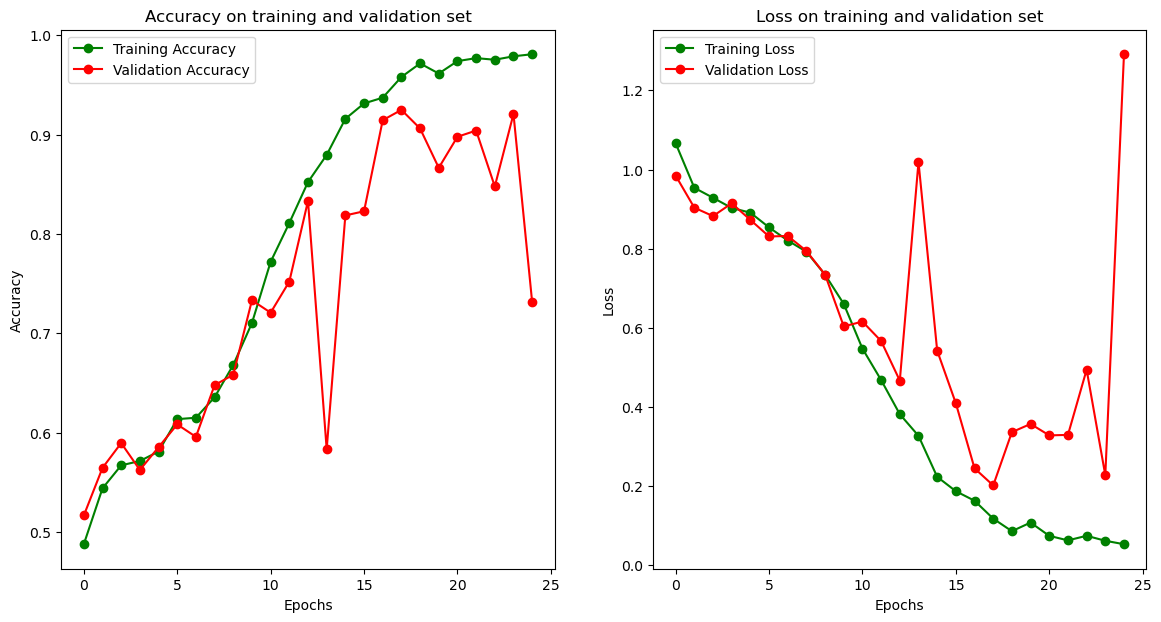

In [365]:
epochs = [i for i in range(num_epochs)]

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(1, 2, figsize = (14, 7))

#sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='green',color='green',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy on training and validation set')

#sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='green',color='green',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss on training and validation set')

fig.show()

#### Predviđanje

In [352]:
Y_pred = model_GGN.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

50/50 [==============================] - 7s 140ms/step


#### Evaluacija modela

In [353]:
print(metrics.classification_report(Y_test, Y_pred, target_names=labels))

                    precision    recall  f1-score   support

      Non_Demented       0.68      1.00      0.81       800
     Mild_Demented       0.99      0.66      0.79       224
 Moderate_Demented       0.92      0.69      0.79        16
Very_Mild_Demented       0.88      0.41      0.56       560

          accuracy                           0.74      1600
         macro avg       0.86      0.69      0.74      1600
      weighted avg       0.79      0.74      0.72      1600



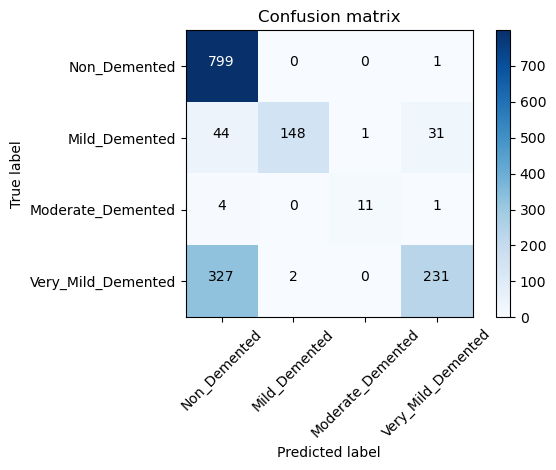

In [397]:
plot_confusion_matrix(metrics.confusion_matrix(Y_test, Y_pred), classes=labels)

### FixRes

- tries to keep a fixed size for the RoC (Region of Classification) used for train time or the crop used for test time
- 

### VGG

- 